In [1]:

import pandas as pd
import numpy as np
from scipy import stats
from math import ceil
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import QuantileTransformer

import xgboost
from xgboost import XGBRegressor    
from xgboost import XGBRegressor as model

def count1(df):
    result=[]
    index=df.index.tolist()
    for i in index:
        x=df.loc[i].sum()
        result.append(x-1)
    return result

def vcl_tr(df):
    df_=df.loc[:, 'VCL1':'VCL16']
    result=[]
    index=df_.index.tolist()
    for i in index:
        x=df_.loc[i].sum()
        if(x>=9):
            result.append(1)
        else:
            result.append(0)
    train['VCL_M']=result
    
def vcl_te(df):
    df_=df.loc[:, 'VCL1':'VCL16']
    result=[]
    index=df_.index.tolist()
    for i in index:
        x=df_.loc[i].sum()
        if(x>=9):
            result.append(1)
        else:
            result.append(0)
    test['VCL_M']=result

def count0(df):
    result=[]
    index=df.index.tolist()
    for i in index:
        x=df.loc[i].sum()
        result.append(x-1)
    return result


def q_tr(df):
    df_=df.loc[:, 'Q1':'Q26']
    result=[]
    index=df_.index.tolist()
    for i in index:
        x=df_.loc[i].tolist()
        re=0
        for j in x:
            re+=((j-1)/4)*100
        result.append(re/(len(x)-1))
    train['Q_m']=result
    
def q_te(df):
    df_=df.loc[:, 'Q1':'Q26']
    result=[]
    index=df_.index.tolist()
    for i in index:
        x=df_.loc[i].tolist()
        re=0
        for j in x:
            re+=((j-1)/4)*100
        result.append(re/(len(x)-1))
    test['Q_m']=result
    
def question_nan(df,col):
    print(col)
    train_q0=df[df[col]==0.0]
    train_q1=df[df[col]!=0.0]
    test_=train_q0
    #결과 없는 test
    train_=train_q1
    #결과 들어가있는 train
    test_=test_.drop(col,axis=1)
    y = train_[col]
    x= train_.drop(col,axis =1)
    model = XGBRegressor(objective='reg:squarederror',learning_rate=0.1,max_depth = 4, n_estimators = 1000,n_jobs=-1)
    model.fit(x, y)
    pred = model.predict(test_)      
    pred=pred.round(0)
    pred=pred.tolist()
    for i in range(len(pred)):
        if(pred[i]<=0):
            pred[i]=1
    index=test_.index.tolist()
    for i in range(len(index)):
        df.at[index[i],col]=pred[i]
        

def age_outlier(df):
    mean=int(df['age'].mean())
    index=df[df['age']>110].index

    for i in index:
        df.at[i,'age']=mean


def family_outlier(df):
    mean=int(df['familysize'].mean())
    index=df[df['familysize']>30].index
    for i in index:
        df.at[i,'familysize']=mean
        
        
def outlier_iqr(data, column): 
    print()

    # lower, upper 글로벌 변수 선언하기     
    global lower, upper    
    
    # 4분위수 기준 지정하기     
    q25, q75 = np.quantile(data[column], 0.25), np.quantile(data[column], 0.75)          
    
    # IQR 계산하기     
    iqr = q75 - q25    
    
    # outlier cutoff 계산하기     
    cut_off = iqr * 1.5          
    
    # lower와 upper bound 값 구하기     
    lower, upper = q25 - cut_off, q75 + cut_off     
    
    print('IQR은',iqr, '이다.')     
    print('lower bound 값은', lower, '이다.')     
    print('upper bound 값은', upper, '이다.')    
    
    # 1사 분위와 4사 분위에 속해있는 데이터 각각 저장하기     
    data1 = data[data[column] > upper]
    #data[data[column] > upper]  = upper
    data2 = data[data[column] < lower] 
    #data[data[column] < lower] = lower
    
    sns.boxplot(data[column])
    plt.show()
    # 이상치 총 개수 구하기
    return print('총 이상치 개수는', data1.shape[0] + data2.shape[0], '이다.')
    



In [2]:
sample = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
Question_te=test.loc[:, 'Q1':'Q26']


In [3]:
country_map = {}

for i, c in enumerate(train['country'].unique()):
    country_map[c] = i
    


# train feature

In [4]:

train['country'] = train['country'].map(country_map)
train = train.fillna(0)#test 결측치 0으로 채우기
#vcl_tr(train)
train=train.drop(train.loc[:,'VCL1':'VCL16'],axis=1)
age_outlier(train)
family_outlier(train)
#q_tr(train)

# test feature

In [5]:

test['country'] = test['country'].map(country_map) #country열 Mapping
test = test.fillna(0)
#vcl_te(test)
test=test.drop(test.loc[:,'VCL1':'VCL16'],axis=1)
age_outlier(test)
family_outlier(test)
#q_te(test)

In [6]:


col=Question_te.columns.tolist()
col

for i in col:
    question_nan(train,i)
    
for i in col:
    question_nan(test,i)



Q1
Q2
Q3
Q4
Q5
Q6
Q7
Q8
Q9
Q10
Q11
Q12
Q13
Q14
Q15
Q16
Q17
Q18
Q19
Q20
Q21
Q22
Q23
Q24
Q25
Q26
Q1
Q2
Q3
Q4
Q5
Q6
Q7
Q8
Q9
Q10
Q11
Q12
Q13
Q14
Q15
Q16
Q17
Q18
Q19
Q20
Q21
Q22
Q23
Q24
Q25
Q26


In [7]:
train=train.drop('index',axis=1)
test=test.drop('index',axis=1)


In [8]:
from sklearn.preprocessing import RobustScaler


promos = ['introelapse','testelapse','surveyelapse']
#MinMaxScaler
#StandardScaler
#RobustScaler
#QuantileTransformer
#PowerTransformer
#KBinsDiscretizer
scaler = QuantileTransformer()
scaler.fit(train[promos])
train[promos] = scaler.transform(train[promos])
test[promos] = scaler.transform(test[promos])



In [9]:
x_train = train.drop('nerdiness',axis=1)
#x_train=x_train.loc[:, 'Q1':'Q26']
y_train = train['nerdiness']



[1. 4. 5. 3. 2.]

IQR은 2.0 이다.
lower bound 값은 0.0 이다.
upper bound 값은 8.0 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


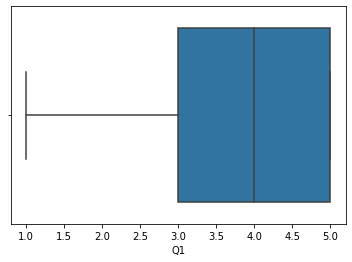

총 이상치 개수는 0 이다.
[5. 4. 3. 2. 1.]

IQR은 1.0 이다.
lower bound 값은 2.5 이다.
upper bound 값은 6.5 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


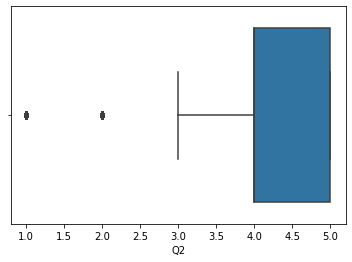

총 이상치 개수는 1893 이다.
[5. 4. 3. 2. 1.]

IQR은 1.0 이다.
lower bound 값은 2.5 이다.
upper bound 값은 6.5 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


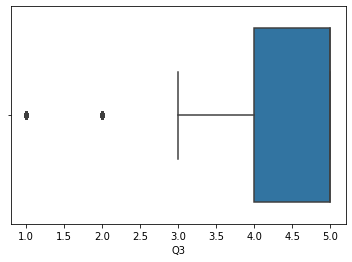

총 이상치 개수는 1290 이다.
[5. 4. 2. 3. 1. 6.]

IQR은 2.0 이다.
lower bound 값은 0.0 이다.
upper bound 값은 8.0 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


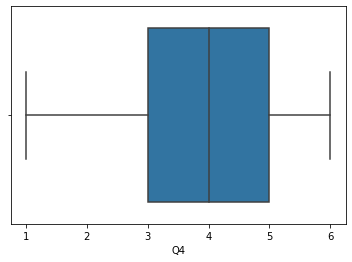

총 이상치 개수는 0 이다.
[1. 4. 3. 5. 2.]

IQR은 2.0 이다.
lower bound 값은 0.0 이다.
upper bound 값은 8.0 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


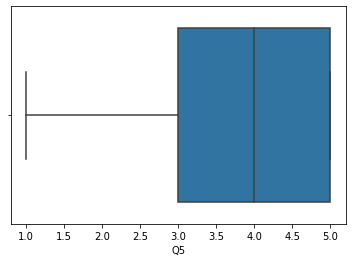

총 이상치 개수는 0 이다.
[4. 5. 3. 2. 1.]

IQR은 2.0 이다.
lower bound 값은 0.0 이다.
upper bound 값은 8.0 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


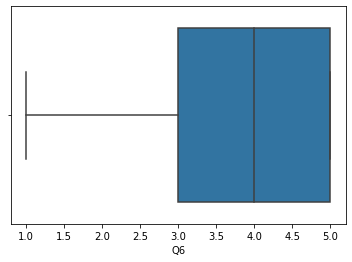

총 이상치 개수는 0 이다.
[5. 4. 3. 2. 1.]

IQR은 1.0 이다.
lower bound 값은 2.5 이다.
upper bound 값은 6.5 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


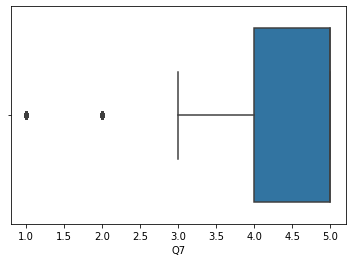

총 이상치 개수는 1384 이다.
[5. 4. 2. 3. 1.]

IQR은 2.0 이다.
lower bound 값은 0.0 이다.
upper bound 값은 8.0 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


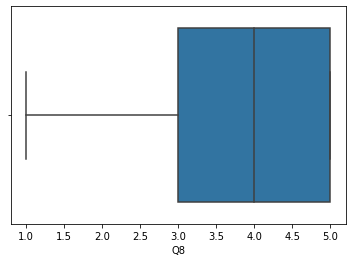

총 이상치 개수는 0 이다.
[1. 3. 4. 5. 2. 6.]

IQR은 2.0 이다.
lower bound 값은 0.0 이다.
upper bound 값은 8.0 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


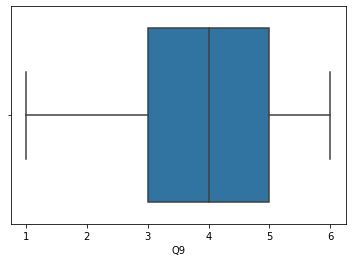

/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


총 이상치 개수는 0 이다.
[3. 4. 5. 2. 1.]

IQR은 1.0 이다.
lower bound 값은 2.5 이다.
upper bound 값은 6.5 이다.


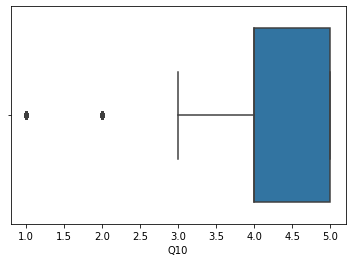

총 이상치 개수는 1186 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[5. 1. 2. 4. 3.]

IQR은 4.0 이다.
lower bound 값은 -5.0 이다.
upper bound 값은 11.0 이다.


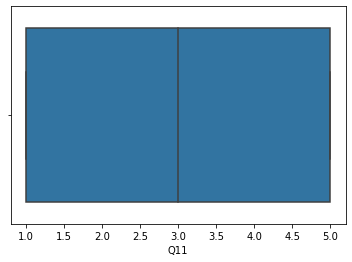

/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


총 이상치 개수는 0 이다.
[5. 4. 2. 3. 1.]

IQR은 2.0 이다.
lower bound 값은 0.0 이다.
upper bound 값은 8.0 이다.


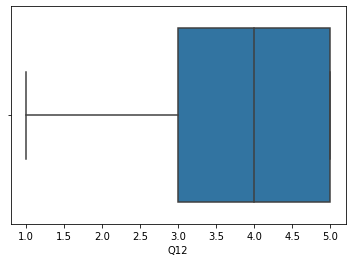

총 이상치 개수는 0 이다.
[5. 2. 3. 1. 4.]

IQR은 2.0 이다.
lower bound 값은 0.0 이다.
upper bound 값은 8.0 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


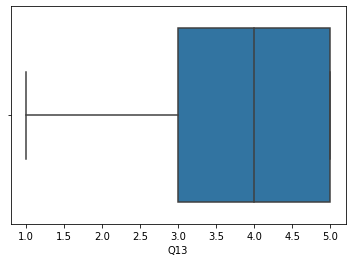

총 이상치 개수는 0 이다.
[5. 3. 4. 2. 1.]

IQR은 2.0 이다.
lower bound 값은 0.0 이다.
upper bound 값은 8.0 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


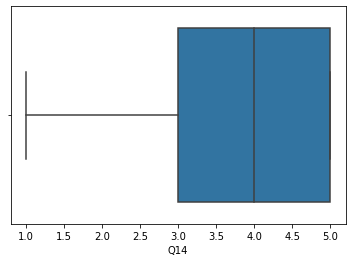

총 이상치 개수는 0 이다.
[5. 1. 4. 3. 2.]

IQR은 3.0 이다.
lower bound 값은 -3.5 이다.
upper bound 값은 8.5 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


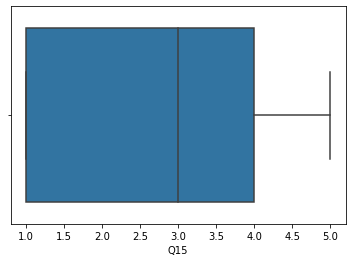

총 이상치 개수는 0 이다.
[5. 2. 3. 1. 4.]

IQR은 3.0 이다.
lower bound 값은 -2.5 이다.
upper bound 값은 9.5 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


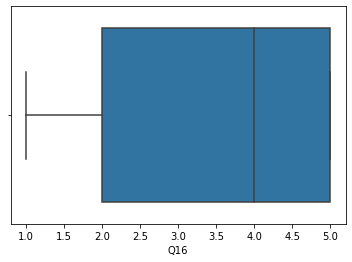

총 이상치 개수는 0 이다.
[5. 4. 1. 2. 3.]

IQR은 2.0 이다.
lower bound 값은 0.0 이다.
upper bound 값은 8.0 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


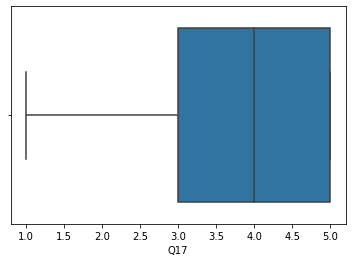

총 이상치 개수는 0 이다.
[1. 5. 3. 2. 4.]

IQR은 2.0 이다.
lower bound 값은 0.0 이다.
upper bound 값은 8.0 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


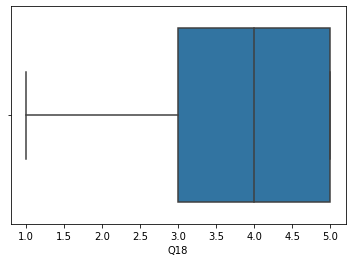

/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


총 이상치 개수는 0 이다.
[5. 1. 4. 3. 2. 6.]

IQR은 3.0 이다.
lower bound 값은 -2.5 이다.
upper bound 값은 9.5 이다.


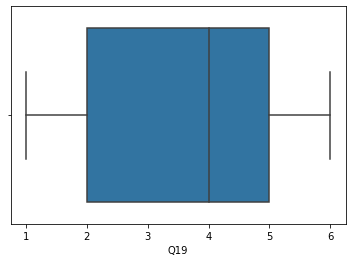

총 이상치 개수는 0 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[5. 3. 2. 4. 1.]

IQR은 2.0 이다.
lower bound 값은 0.0 이다.
upper bound 값은 8.0 이다.


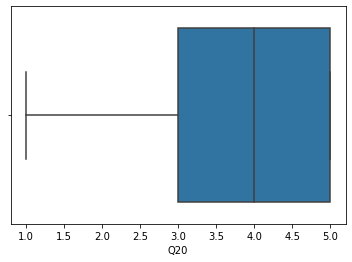

총 이상치 개수는 0 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[1. 2. 3. 4. 5.]

IQR은 4.0 이다.
lower bound 값은 -5.0 이다.
upper bound 값은 11.0 이다.


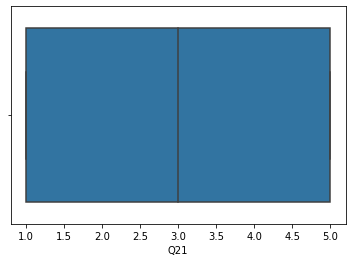

총 이상치 개수는 0 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[5. 1. 4. 2. 3.]

IQR은 2.0 이다.
lower bound 값은 -2.0 이다.
upper bound 값은 6.0 이다.


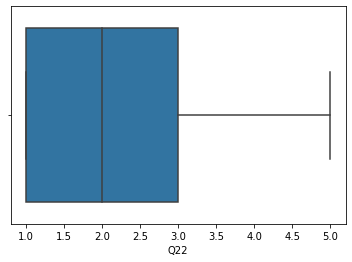

/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


총 이상치 개수는 0 이다.
[1. 5. 2. 3. 4.]

IQR은 2.0 이다.
lower bound 값은 0.0 이다.
upper bound 값은 8.0 이다.


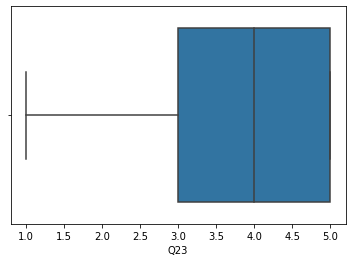

/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


총 이상치 개수는 0 이다.
[5. 3. 4. 1. 2.]

IQR은 1.0 이다.
lower bound 값은 2.5 이다.
upper bound 값은 6.5 이다.


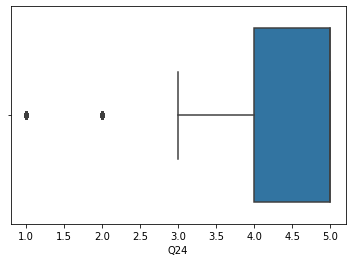

총 이상치 개수는 823 이다.
[1. 2. 4. 3. 5.]

IQR은 2.0 이다.
lower bound 값은 -1.0 이다.
upper bound 값은 7.0 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


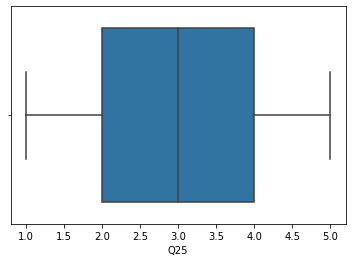

총 이상치 개수는 0 이다.
[1. 5. 2. 4. 3.]

IQR은 1.0 이다.
lower bound 값은 2.5 이다.
upper bound 값은 6.5 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


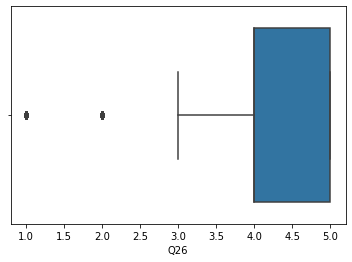

총 이상치 개수는 1283 이다.
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137]

IQR은 15.0 이다.
lower bound 값은 -22.5 이다.
upper bound 값은 37.5 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


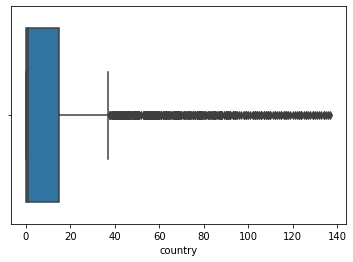

총 이상치 개수는 1339 이다.
[0.18718719 0.32782783 0.46646647 ... 0.94534907 0.97714267 0.91993485]

IQR은 0.47847847847847846 이다.
lower bound 값은 -0.44744744744744736 이다.
upper bound 값은 1.4664664664664664 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


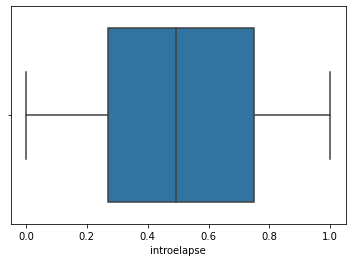

총 이상치 개수는 0 이다.
[9.79668065e-01 2.83283283e-01 5.24524525e-01 6.40140140e-01
 9.82982983e-01 4.43943944e-01 3.15315315e-01 2.20220220e-02
 8.32832833e-01 7.17717718e-01 2.73273273e-01 5.62562563e-01
 9.25925926e-02 9.71319849e-01 6.65665666e-01 9.68255291e-01
 2.16716717e-01 4.00900901e-01 5.15015015e-01 5.53553554e-01
 2.51251251e-01 7.54254254e-01 9.81850240e-01 8.60360360e-01
 7.12712713e-01 4.33433433e-01 3.47347347e-01 8.00800801e-01
 8.82882883e-01 7.00700701e-01 1.38638639e-01 4.60460460e-02
 7.80780781e-02 3.26326326e-01 2.92792793e-01 1.29129129e-01
 1.20120120e-01 2.39239239e-01 6.94194194e-01 6.52652653e-01
 3.68368368e-01 8.71371371e-01 7.63263263e-01 6.72172172e-01
 4.92992993e-01 5.80080080e-01 7.75775776e-01 9.76999504e-01
 1.10610611e-01 4.11411411e-01 1.57657658e-01 1.85185185e-02
 9.52952953e-01 1.97697698e-01 8.12812813e-01 8.07807808e-01
 8.24824825e-01 9.72071429e-01 7.71771772e-01 1.01101101e-01
 3.03803804e-01 9.71901312e-01 5.98098098e-01 4.71471471e-01
 8.96896

/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


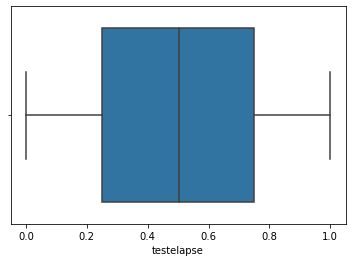

/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


총 이상치 개수는 0 이다.
[6.00600601e-04 2.13213213e-01 9.15915916e-02 3.34334334e-01
 7.48748749e-01 5.69569570e-01 4.99499499e-01 1.60160160e-01
 7.38238238e-01 5.74574575e-01 6.34134134e-01 5.12012012e-01
 7.80780781e-02 4.79979980e-01 5.58058058e-01 6.38638639e-01
 2.37737738e-01 7.23723724e-01 5.64064064e-01 7.90290290e-01
 6.84184184e-01 2.67267267e-01 7.20220220e-01 7.15715716e-01
 3.76376376e-01 1.12112112e-01 4.86986987e-01 5.18018018e-01
 8.37337337e-01 2.31231231e-01 1.10110110e-02 8.80880881e-01
 4.60460460e-01 5.05505506e-01 4.20920921e-01 6.65665666e-02
 2.44244244e-01 7.51751752e-01 9.92714827e-01 8.20820821e-01
 7.58258258e-01 5.86086086e-01 9.89433855e-01 9.11411411e-01
 8.25825826e-02 7.28228228e-01 8.87887888e-01 2.10210210e-02
 9.54621288e-01 1.71171171e-01 4.40940941e-01 4.26926927e-01
 7.74774775e-01 4.53453453e-01 3.07807808e-01 9.05905906e-01
 5.35535536e-01 8.55355355e-01 9.64764765e-01 2.73773774e-01
 1.99199199e-01 4.15415415e-02 1.07107107e-01 7.54754755e-01
 6.43643

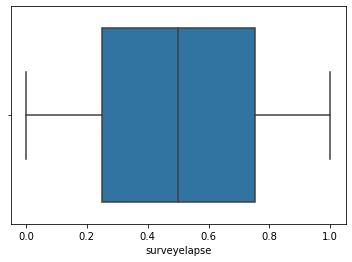

총 이상치 개수는 0 이다.
[4. 1. 3. 5. 2. 0.]



/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


IQR은 1.0 이다.
lower bound 값은 0.5 이다.
upper bound 값은 4.5 이다.


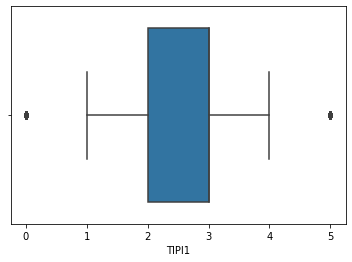

총 이상치 개수는 1083 이다.
[3. 2. 1. 4. 5. 0.]

IQR은 1.0 이다.
lower bound 값은 1.5 이다.
upper bound 값은 5.5 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


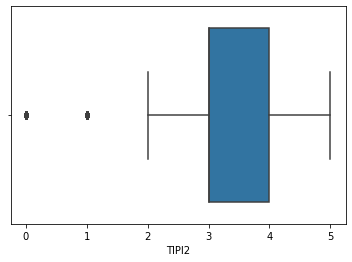

총 이상치 개수는 1652 이다.
[5. 3. 4. 1. 2. 0.]

IQR은 1.0 이다.
lower bound 값은 1.5 이다.
upper bound 값은 5.5 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


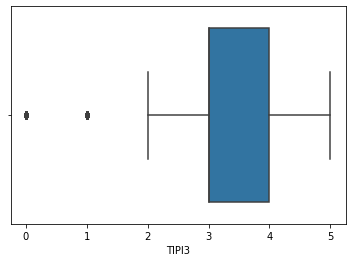

총 이상치 개수는 675 이다.
[1. 5. 4. 3. 2. 0.]

IQR은 1.0 이다.
lower bound 값은 1.5 이다.
upper bound 값은 5.5 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


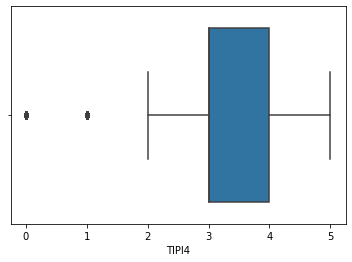

총 이상치 개수는 1472 이다.
[3. 5. 4. 2. 1. 0.]

IQR은 2.0 이다.
lower bound 값은 0.0 이다.
upper bound 값은 8.0 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


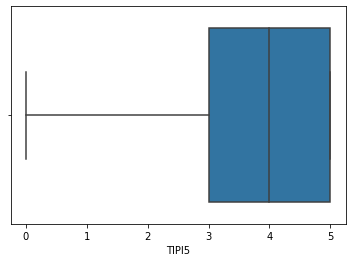

총 이상치 개수는 0 이다.
[5. 2. 3. 4. 1. 0.]

IQR은 2.0 이다.
lower bound 값은 0.0 이다.
upper bound 값은 8.0 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


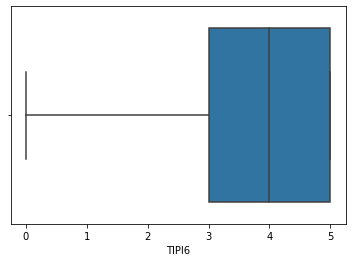

총 이상치 개수는 0 이다.
[5. 3. 4. 2. 1. 0.]

IQR은 1.0 이다.
lower bound 값은 1.5 이다.
upper bound 값은 5.5 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


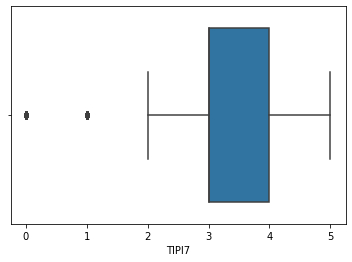

총 이상치 개수는 615 이다.
[3. 1. 4. 5. 2. 0.]

IQR은 2.0 이다.
lower bound 값은 -1.0 이다.
upper bound 값은 7.0 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


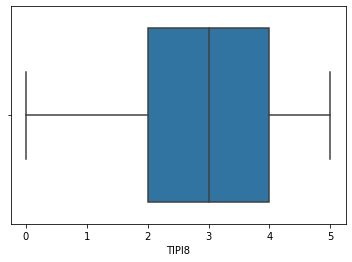

총 이상치 개수는 0 이다.
[5. 2. 3. 4. 1. 0.]

IQR은 1.0 이다.
lower bound 값은 1.5 이다.
upper bound 값은 5.5 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


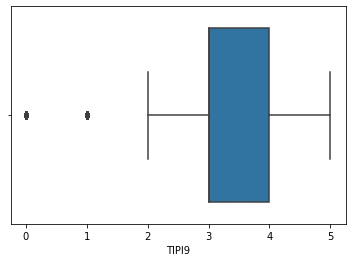

총 이상치 개수는 1270 이다.
[3. 2. 1. 4. 5. 0.]

IQR은 2.0 이다.
lower bound 값은 -2.0 이다.
upper bound 값은 6.0 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


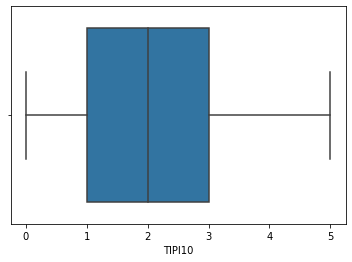

총 이상치 개수는 0 이다.
[2. 4. 1. 3. 0.]

IQR은 1.0 이다.
lower bound 값은 0.5 이다.
upper bound 값은 4.5 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


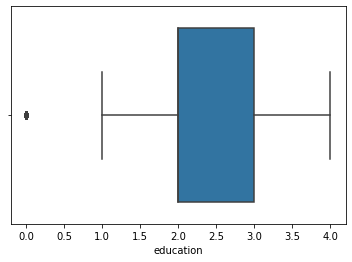

총 이상치 개수는 167 이다.
[1 2 3 0]

IQR은 1.0 이다.
lower bound 값은 0.5 이다.
upper bound 값은 4.5 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


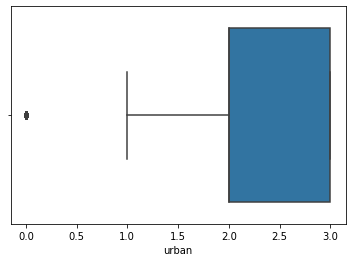

/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


총 이상치 개수는 82 이다.
[3. 2. 1. 0.]

IQR은 1.0 이다.
lower bound 값은 -0.5 이다.
upper bound 값은 3.5 이다.


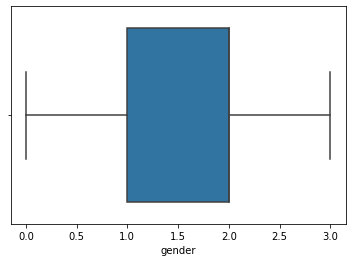

총 이상치 개수는 0 이다.
[1. 2. 0.]

IQR은 1.0 이다.
lower bound 값은 -0.5 이다.
upper bound 값은 3.5 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


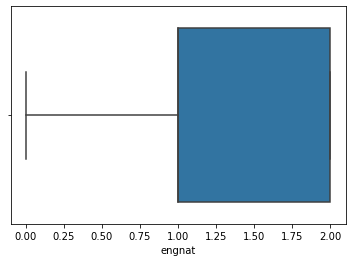

/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


총 이상치 개수는 0 이다.
[ 20  49  43  17  18  26  40  34  29  24  13  14  16  19  15  23  32  22
  25  27  33  41  21  50  64  44  31  35  67  48  38  46  58  59  52  42
  37  55  36  45  28  47  30  39  54  53  69  57  72  51  56  65  60  61
 100  66  73  70  68  62  71  78  76  63  74  88  75  77  99  81  80]

IQR은 10.0 이다.
lower bound 값은 2.0 이다.
upper bound 값은 42.0 이다.


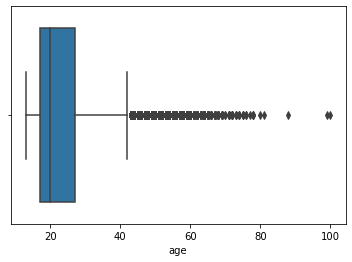

총 이상치 개수는 1230 이다.
[2. 1. 3. 0.]

IQR은 0.0 이다.
lower bound 값은 1.0 이다.
upper bound 값은 1.0 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


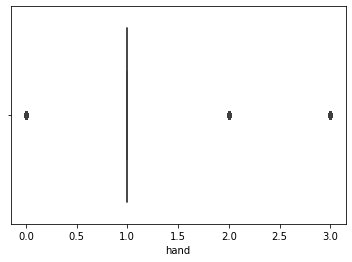

총 이상치 개수는 2206 이다.
[12.  2.  1.  7. 10.  3.  4.  6.  9.  5.  8.  0. 11.]



/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


IQR은 5.0 이다.
lower bound 값은 -6.5 이다.
upper bound 값은 13.5 이다.


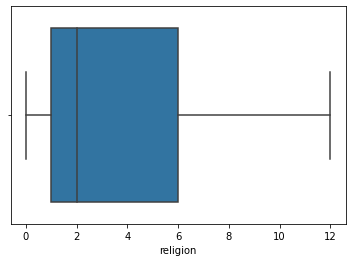

총 이상치 개수는 0 이다.
[4. 1. 2. 5. 0. 3.]

IQR은 1.0 이다.
lower bound 값은 -0.5 이다.
upper bound 값은 3.5 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


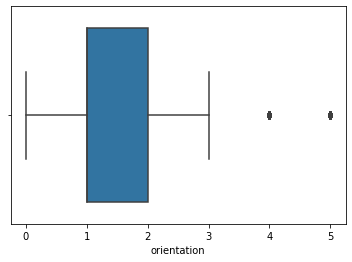

총 이상치 개수는 2126 이다.
[2. 1. 0.]

IQR은 1.0 이다.
lower bound 값은 -0.5 이다.
upper bound 값은 3.5 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


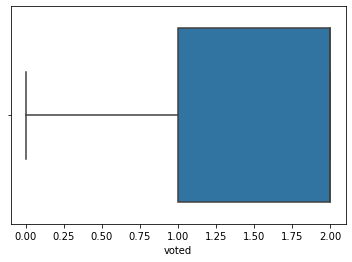

총 이상치 개수는 0 이다.
[1. 2. 3. 0.]



/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


IQR은 0.0 이다.
lower bound 값은 1.0 이다.
upper bound 값은 1.0 이다.


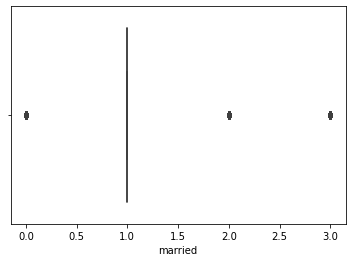

총 이상치 개수는 2247 이다.
[ 4.  2.  1.  3.  5.  0.  8.  6. 23. 13.  7. 10.  9. 12. 14. 19. 16. 11.
 17.]

IQR은 1.0 이다.
lower bound 값은 0.5 이다.
upper bound 값은 4.5 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


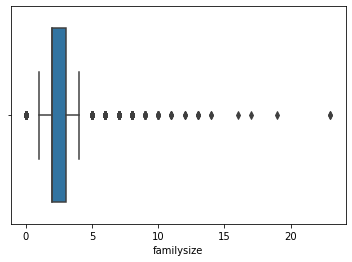

총 이상치 개수는 1303 이다.
[2. 1. 0.]

IQR은 0.0 이다.
lower bound 값은 2.0 이다.
upper bound 값은 2.0 이다.


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


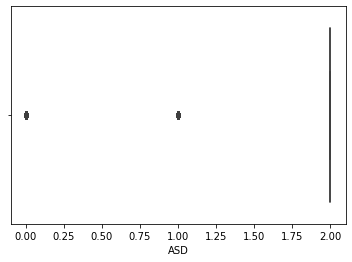

총 이상치 개수는 1003 이다.
[1 0]



/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


IQR은 1.0 이다.
lower bound 값은 -1.5 이다.
upper bound 값은 2.5 이다.


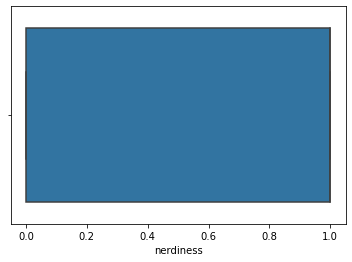

총 이상치 개수는 0 이다.


In [10]:
col=train.columns
for i in col:
    print(train[i].unique())
    outlier_iqr(train,i)

In [11]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42, n_jobs=-1)


from sklearn.model_selection import KFold, GridSearchCV #하이퍼파라미터 튜닝을 위한 불러오기
from sklearn.metrics import accuracy_score

model_param_grid = {'n_estimators' : [100, 1000,2000, 3000]} # Default(100)대비 큰값으로 Dictionary구성

model_grid = GridSearchCV(model, param_grid = model_param_grid, scoring="accuracy",n_jobs=-1,verbose=1) #훈련 (장치 사양에 따라 시간이 걸릴 수 있음)
model_grid.fit(x_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1, param_grid={'n_estimators': [100, 1000, 2000, 3000]},
             scoring='accuracy', verbose=1)

In [12]:
gcv=GridSearchCV(model, param_grid=model_param_grid, scoring='f1', n_jobs=-1)
gcv.fit(x_train.values,y_train.values)
print('final params', gcv.best_params_)   # 최적의 파라미터 값 출력



final params {'n_estimators': 3000}


In [13]:
model = RandomForestClassifier(n_estimators=3000,random_state=42, n_jobs=-1)




In [14]:
model.fit(x_train, y_train) #학습
pred = model.predict_proba(test)[:,1] #proba를 통해 확률값으로 변환
sample['nerdiness'] = pred
sample.to_csv('result8.15_2.csv',index=False)


In [15]:

sample['nerdiness'].sum()
#19384.0
#19228.0  result8.6_3
# 19729.191 result8.9_1
# 19737.59333333333 result8.11_2.csv   0.9026266776	
# 19722.430333333334  result8.11_3.csv   0.9021614897
#19731.831  result8.11_4 0.9026705801
# 19732.594666666664  result8.14_1 0.90273
# 19700.586000000003 result8.15_1. 
# 

19728.691666666666

<Figure size 1080x576 with 0 Axes>

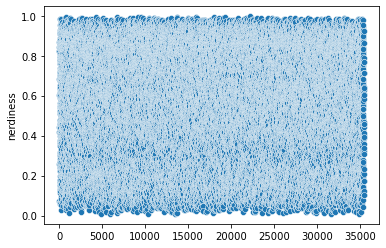

<Figure size 1080x576 with 0 Axes>

In [16]:
sns.scatterplot(x=sample.index,y=sample['nerdiness'],sizes = (300,350))
plt.figure(figsize=(15,8))


In [17]:
def plot_feature_importance(model, X_train, figsize=(12, 6)):
    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=figsize)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X_train.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()            
                

        

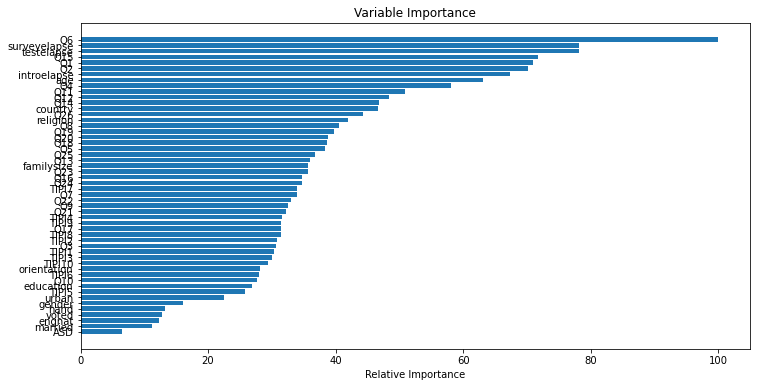

In [18]:
plot_feature_importance(model,x_train)